In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import feature
import tensorflow
import optuna
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, ReLU, Add, Dropout, Input, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


Total number of images:  5631

Number of classes:  4

Class labels:  ['cloudy', 'desert', 'green_area', 'water']

Number of images in 'cloudy': 1500

Number of images in 'desert': 1131

Number of images in 'green_area': 1500

Number of images in 'water': 1500

Image dimensions: (128, 128, 3)


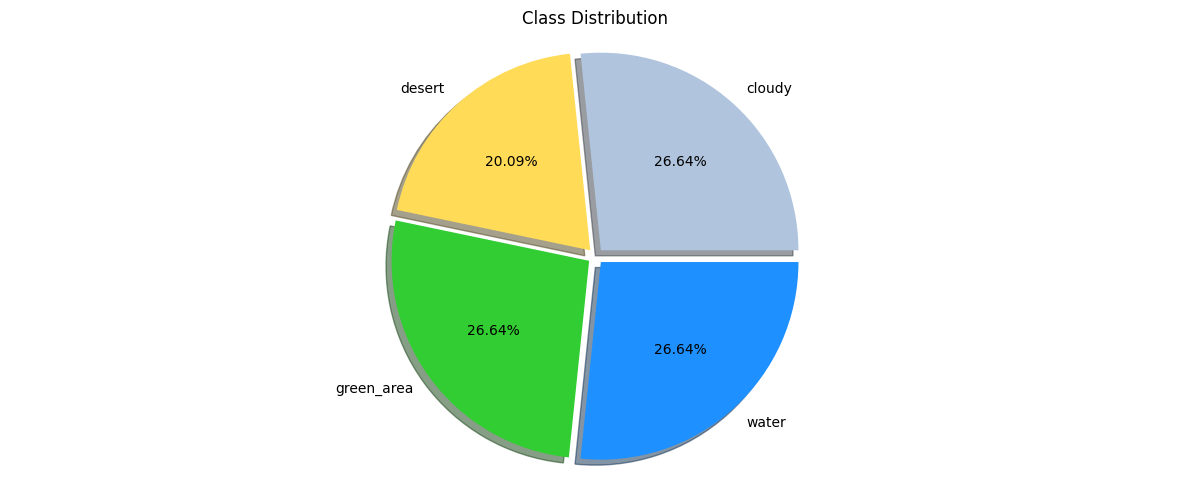

In [14]:
data_dir = './data'

def load_dataset(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_folder = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels), class_names

def describe_dataset(images, labels, class_names):
    print("\nTotal number of images: ", len(images))
    print("\nNumber of classes: ", len(class_names))
    print("\nClass labels: ", class_names)
    class_counts = np.bincount(labels)
    for i, class_name in enumerate(class_names):
        print(f"\nNumber of images in '{class_name}':", class_counts[i])
    if len(images) > 0:
        print("\nImage dimensions:", images[0].shape)

def plot_class_distribution(class_counts, class_names):
    plt.figure(figsize=(12, 5))
    # plt.subplot(1,2,1)
    # plt.barh(class_names, class_counts, color='lightcoral', height=0.5)
    # plt.ylabel('Class Labels')
    # plt.xlabel('Number of Images')
    # plt.title('Class Distribution')
    # plt.subplot(1, 2, 2)
    color_mapping = {
        'desert': '#FFDB58',
        'green_area': '#32CD32',
        'water': '#1E90FF',
        'cloudy': '#B0C4DE'
    }
    colors = [color_mapping[name] for name in class_names]
    explodes = [0.04, 0.04, 0.04, 0.04]
    plt.pie(class_counts, labels=class_names, colors=colors, shadow=True, explode=explodes, autopct="%.2f%%")
    plt.axis('equal')
    plt.title('Class Distribution')
    plt.tight_layout()
    plt.show()

images, labels, class_names = load_dataset(data_dir)
describe_dataset(images, labels, class_names)
plot_class_distribution(np.bincount(labels), class_names)

In [15]:
images = images.astype('float32') / 255.0
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)
input_shape = (128, 128, 3)
num_classes = len(class_names)

In [12]:
def create_model(input_shape, num_classes, num_layers, neurons_list, activation_list, optimizer_type):
    model = Sequential()

    model.add(Conv2D(neurons_list[0], (3, 3), activation=activation_list[0], input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(1, num_layers):
        model.add(Conv2D(neurons_list[i], (3, 3), activation=activation_list[i]))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation=activation_list[-2]))
    model.add(Dense(num_classes, activation=activation_list[-1]))

    if optimizer_type == 'adam':
        optimizer = Adam()
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_type == 'sgd':
        optimizer = SGD(momentum=0.9)
    else:
        optimizer = Adam()
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [13]:
def tune_model_2_Layer(X_train, y_train, X_val, y_val, input_shape, num_classes, 
               num_layers=2, 
               neurons_list=[[8, 16], [16, 32], [32, 64], [64, 128]], 
               activation_list=[['relu', 'relu'], ['relu', 'softmax'], ['tanh', 'softmax']],
               optimizer_list=['adam', 'rmsprop', 'sgd'], 
               batch_size_list=[16, 32, 64], 
               epochs=10, early_stopping_patience=3):
    
    best_val_acc = 0
    best_model = None
    best_params = None
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

    for neurons in neurons_list:
        for activations in activation_list:
            for optimizer in optimizer_list:
                for batch_size in batch_size_list:
                    print(f"Training with {num_layers} layers, {neurons} neurons, {activations} activation functions, optimizer {optimizer}, batch size {batch_size}")
                    model = create_model(input_shape, num_classes, num_layers, neurons, activations, optimizer)
                    history = model.fit(X_train, y_train, 
                                        validation_data=(X_val, y_val), 
                                        epochs=epochs, 
                                        batch_size=batch_size, 
                                        callbacks=[early_stopping], 
                                        verbose=0)
                        
                    val_acc = history.history['val_accuracy'][-1]
                    print(f"Validation accuracy: {val_acc:.4f}")
                        
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_model = model
                        best_params = {
                                'num_layers': num_layers,
                                'neurons': neurons,
                                'activations': activations,
                                'optimizer': optimizer,
                                'batch_size': batch_size
                            }
    print(f"Best model achieved a validation accuracy of {best_val_acc:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_model, best_params



In [ ]:

best_model, best_params = tune_model_2_Layer(X_train, y_train, X_val, y_val, input_shape, num_classes)
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_acc)

Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer adam, batch size 16
Validation accuracy: 0.2911
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer adam, batch size 32
Validation accuracy: 0.2485
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer adam, batch size 64
Validation accuracy: 0.2911
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer rmsprop, batch size 16
Validation accuracy: 0.2911
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer rmsprop, batch size 32
Validation accuracy: 0.2911
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer rmsprop, batch size 64
Validation accuracy: 0.2911
Training with 2 layers, [8, 16] neurons, ['relu', 'relu'] activation functions, optimizer sgd, batch size 16
Validation accuracy: 0.2911
Training with 2 layers, [8

In [6]:
def create_model(input_shape, num_classes, num_layers, neurons_list, activation_list, optimizer_type):
    model = Sequential()

    activation_dict = {
        'relu': 'relu', 
        'tanh': 'tanh',
        'elu': 'elu',
        'leakyrelu': LeakyReLU(),
        'softmax': 'softmax'
    }

    model.add(Conv2D(neurons_list[0], (3, 3), activation=None, input_shape=input_shape))
    model.add(Activation(activation_dict[activation_list[0]]))
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(1, num_layers):
        model.add(Conv2D(neurons_list[i], (3, 3), activation=None))
        model.add(Activation(activation_dict[activation_list[i]]))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation=None))
    model.add(Activation(activation_dict[activation_list[-2]]))

    model.add(Dense(num_classes, activation=activation_dict[activation_list[-1]]))

    if optimizer_type == 'adam':
        optimizer = Adam()
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_type == 'sgd':
        optimizer = SGD(momentum=0.9)
    else:
        optimizer = Adam()
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
def objective(trial, X_train, y_train, X_val, y_val, input_shape, num_classes):
    num_layers = 3
    neurons = [
        trial.suggest_categorical('neurons_1', [8, 16, 32, 64, 128]),
        trial.suggest_categorical('neurons_2', [8, 16, 32, 64, 128]),
        trial.suggest_categorical('neurons_3', [8, 16, 32, 64, 128])
    ]
    
#     activation_combinations = [
#     ('relu', 'relu', 'relu'),
#     ('relu', 'relu', 'softmax'),
#     ('relu', 'tanh', 'relu'),
#     ('leakyrelu', 'leakyrelu', 'softmax'),
#     ('elu', 'elu', 'softmax')
# ]
    
    activations = [
        trial.suggest_categorical('activations_1', ['relu', 'leakyrelu', 'elu']),
        trial.suggest_categorical('activations_2', ['relu', 'tanh', 'leakyrelu', 'elu']),
        trial.suggest_categorical('activations_3', ['relu', 'softmax'])
    ]
    
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 10

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    model = create_model(input_shape, num_classes, num_layers, neurons, activations, optimizer)
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        callbacks=[early_stopping], 
                        verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    return 1.0 - val_acc 


In [8]:
def tune_model_optuna(X_train, y_train, X_val, y_val, input_shape, num_classes, n_trials=30):

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, input_shape, num_classes), n_trials=n_trials)

    best_trial = study.best_trial
    best_params = best_trial.params

    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print(f"  Params: {best_params}")
    
    best_model = create_model(input_shape, num_classes, 3,
                              [best_params['neurons_1'], best_params['neurons_2'], best_params['neurons_3']], 
                              [best_params['activations_1'], best_params['activations_2'], best_params['activations_3']], 
                              best_params['optimizer'])

    best_model.fit(X_train, y_train, 
                   validation_data=(X_val, y_val), 
                   epochs=10,
                   batch_size=best_params['batch_size'], 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
                   verbose=1)

    return best_model, best_params

In [9]:
best_model, best_params = tune_model_optuna(X_train, y_train, X_val, y_val, input_shape, num_classes)

[I 2024-11-18 13:20:20,794] A new study created in memory with name: no-name-716b3f9e-4dc7-433e-bcea-e8db74c2b5bc


[I 2024-11-18 13:32:13,443] Trial 0 finished with value: 0.16923075914382935 and parameters: {'neurons_1': 64, 'neurons_2': 128, 'neurons_3': 64, 'activations_1': 'leakyrelu', 'activations_2': 'elu', 'activations_3': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: 0.16923075914382935.
[I 2024-11-18 13:33:51,347] Trial 1 finished with value: 0.7088757455348969 and parameters: {'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 32, 'activations_1': 'leakyrelu', 'activations_2': 'elu', 'activations_3': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 0 with value: 0.16923075914382935.
[I 2024-11-18 13:37:05,026] Trial 2 finished with value: 0.1928994059562683 and parameters: {'neurons_1': 32, 'neurons_2': 128, 'neurons_3': 16, 'activations_1': 'relu', 'activations_2': 'elu', 'activations_3': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 0 with value: 0.16923075914382935.
[I 2024-11-18 13:38:50,744] Trial 3 finished with v

Best trial:
  Value: 0.0710059404373169
  Params: {'neurons_1': 16, 'neurons_2': 16, 'neurons_3': 8, 'activations_1': 'elu', 'activations_2': 'leakyrelu', 'activations_3': 'softmax', 'optimizer': 'adam', 'batch_size': 16}
Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5628 - loss: 0.7973 - val_accuracy: 0.7953 - val_loss: 0.4242
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7621 - loss: 0.4845 - val_accuracy: 0.8533 - val_loss: 0.3419
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8369 - loss: 0.3855 - val_accuracy: 0.8947 - val_loss: 0.2827
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8591 - loss: 0.3401 - val_accuracy: 0.7988 - val_loss: 0.4382
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8414 - loss: 0.3799 - val_accuracy: 0.8888 - val_loss: 0.2958
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8759 - loss: 0.3037 - val_accuracy: 0.8923 - val_loss: 0.2857


In [10]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8634 - loss: 0.3591

Test accuracy: 0.8792899250984192


In [16]:
def create_model(input_shape, num_classes):
    model = Sequential()

    activation_dict = {
        'relu': 'relu', 
        'tanh': 'tanh',
        'elu': 'elu',
        'leakyrelu': LeakyReLU(),
        'softmax': 'softmax'
    }

    model.add(Conv2D(16, (3, 3), activation=None, input_shape=input_shape))
    model.add(Activation(activation_dict['elu']))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(16, (3, 3), activation=None, input_shape=input_shape))
    model.add(Activation(activation_dict['leakyrelu']))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(8, (3, 3), activation=None, input_shape=input_shape))
    model.add(Activation(activation_dict['softmax']))
    model.add(MaxPooling2D((2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation=None))
    model.add(Activation(activation_dict['leakyrelu']))

    model.add(Dense(num_classes, activation=activation_dict['softmax']))
    optimizer = Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
input_shape = (128, 128, 3)
num_classes = len(class_names)
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,276 (801.86 KB)

 Trainable params: 205,276 (801.86 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10, 
                    batch_size=16)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_acc)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8774 - loss: 0.2717 - val_accuracy: 0.8923 - val_loss: 0.2537
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8942 - loss: 0.2727 - val_accuracy: 0.9231 - val_loss: 0.2011
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8989 - loss: 0.2537 - val_accuracy: 0.9266 - val_loss: 0.1945
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8906 - loss: 0.2624 - val_accuracy: 0.9065 - val_loss: 0.2219
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9042 - loss: 0.2309 - val_accuracy: 0.9195 - val_loss: 0.1905
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9102 - loss: 0.2231 - val_accuracy: 0.9420 - val_loss: 0.1686
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9170 - loss: 0.2124 - val_accuracy: 0.9112 - val_loss: 0.2095
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9252 - loss: 0.2015 - val_accu

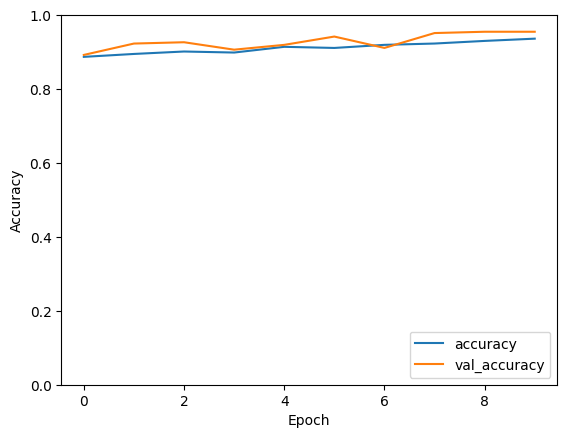

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [3]:
def load_dataset(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_folder = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels), class_names


images, labels, class_names = load_dataset(data_dir, target_size=(224, 224))
images = images.astype('float32') / 255.0 
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)


In [ ]:
def conv_block(x, filters, kernel_size=3, strides=1):
    """Standard convolution block."""
    x_shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def identity_block(x, filters):
    """Identity block in ResNet architecture (2 convolutions and skip connection)."""
    x_shortcut = x

    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)
    return x

def resnet18(input_shape=(224, 224, 3), num_classes=4):
    """ResNet-18 architecture."""
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
 
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = conv_block(x, 128, strides=2)
    x = identity_block(x, 128)

    x = conv_block(x, 256, strides=2)
    x = identity_block(x, 256)

    x = conv_block(x, 512, strides=2)
    x = identity_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    
    return model


In [5]:
model = resnet18(input_shape=(224, 224, 3), num_classes=len(class_names))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 7,915,396 (30.19 MB)

 Trainable params: 7,909,380 (30.17 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.7307 - loss: 0.7990 - val_accuracy: 0.4012 - val_loss: 3.6667
Epoch 2/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.8314 - loss: 0.4417 - val_accuracy: 0.3550 - val_loss: 2.2934
Epoch 3/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.8634 - loss: 0.3329 - val_accuracy: 0.7112 - val_loss: 0.6170
Epoch 4/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 470s 4s/step - accuracy: 0.8554 - loss: 0.3545 - val_accuracy: 0.6320 - val_loss: 1.1424
Epoch 5/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.8817 - loss: 0.3025 - val_accuracy: 0.8793 - val_loss: 0.3420
Epoch 6/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.8814 - loss: 0.3150 - val_accuracy: 0.6615 - val_loss: 1.1946
Epoch 7/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.8475 - loss: 0.3629 - val_accuracy: 0.7882 - val_loss: 0.7227
Epoch 8/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 451s 4s/step - accuracy: 0.8667 - loss: 0.3025 - val_accu

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.8554 - loss: 0.4004

Test accuracy: 0.8745561838150024


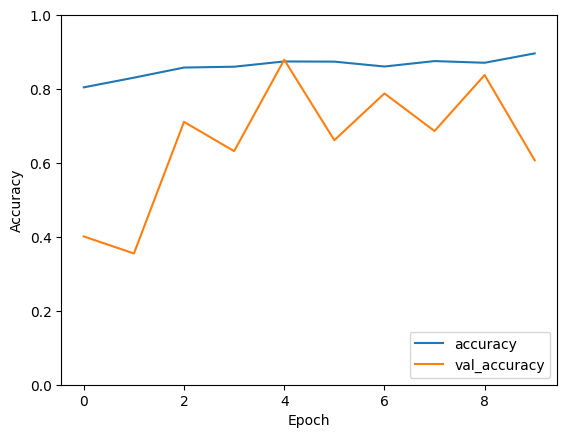

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()